In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_swiss_roll

# Part 1: Score matching

# 1-1 load dataset


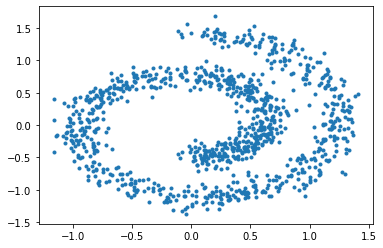

In [3]:
# generate the swiss roll dataset
xnp, _ = make_swiss_roll(1000, noise=1.0)
xtns = torch.as_tensor(xnp[:, [0, 2]] / 10.0, dtype=torch.float32)
dset = torch.utils.data.TensorDataset(xtns)

# show the samples

plt.plot(xtns[:, 0], xtns[:, 1], 'C0.')

In [4]:
xtns.shape

torch.Size([1000, 2])

# 1-2 Neural Network for: $\mathbf{s_\theta}(\mathbf{x})$

In [5]:
# score_network takes input of 2 dimension and returns the output of the same size
score_network = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)

# 1-3 Score Matching


Loss function:
$$\begin{equation}
\mathcal{L}(\theta) = \mathbb{E}_{\mathbf{x}\sim p(\mathbf{x})}\left[\frac{1}{2} \left\lVert\mathbf{s_\theta}(\mathbf{x})\right\rVert^2 + \mathrm{tr}\left(\nabla_\mathbf{x} \mathbf{s_\theta}(\mathbf{x})\right)\right].
\end{equation}$$

In [6]:
!pip install functorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from functorch import jacrev, vmap


def calc_loss(score_net: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    score = score_net(x)  # score: (batch_size, 2)
    jacobian = vmap(jacrev(score_net))(x)
    score_loss_1 = 0.5 * (torch.norm(score, dim=1) ** 2)
    score_loss_2 = jacobian.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
    
    return torch.mean(score_loss_1 + score_loss_2)


# 1-4 Training

In [8]:
# start the training loop
import time
optim = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size = 32, shuffle=True)
t0 = time.time()
train_loss = []
for i_epoch in range(5000):
    total_loss = 0
    for data, in dloader:
        # print(data)

        optim.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        optim.step()
        
        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]
    
    # print the training stats
    if i_epoch % 250 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")
    train_loss = np.append(train_loss ,loss.item())


0 (0.39099955558776855s): -0.07634089222550391
250 (46.3868944644928s): -10.94211376953125
500 (83.3249580860138s): -20.219703704833986
750 (123.1351330280304s): -38.67955676269531
1000 (162.7732276916504s): -44.428460510253906
1250 (203.70537996292114s): -48.879791717529294
1500 (245.5563395023346s): -50.77319790649414
1750 (288.97051429748535s): -54.75424279785156
2000 (334.17230463027954s): -56.93018563842774
2250 (374.8728771209717s): -59.32458282470703
2500 (415.4845154285431s): -61.91180126953125
2750 (456.1122353076935s): -63.381320014953616
3000 (497.408460855484s): -65.2464873046875
3250 (538.3034961223602s): -67.90019325256348
3500 (579.6631636619568s): -68.77547387695313
3750 (622.5111465454102s): -72.12169065856934
4000 (663.7954411506653s): -74.52890525817871
4250 (704.2462675571442s): -77.40025720214844
4500 (744.7067868709564s): -80.60355187988282
4750 (787.5191361904144s): -83.97239590454102


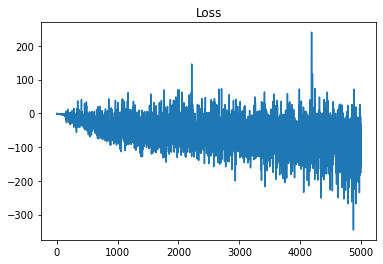

In [9]:
plt.plot(train_loss)
plt.title('Loss')
plt.show()

# 1-5 Generation

Generating samples using Langevin dynamics:

$$\begin{equation}
    \mathbf{x}_{i + 1} = \mathbf{x}_i + \varepsilon \nabla_\mathbf{x}\mathrm{log}\ p(\mathbf{x}) + \sqrt{2\varepsilon} \mathbf{z}_i
\end{equation}$$

where $\mathbf{z}_i\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a random number sampled from the normal distribution.

In [10]:
def generate_samples(score_net: torch.nn.Module, nsamples: int, eps: float = 0.001, nsteps: int = 1000) -> torch.Tensor:
    new_x = torch.rand(nsamples, 2)
    
    for i in range(nsteps):
      draw = torch.randn_like(new_x)
      new_x = new_x + (eps * score_net(new_x)) +  ((2 * eps) ** 0.5) * draw
      
    return new_x
    

with torch.no_grad():
  samples = generate_samples(score_network, 1000)
    

Text(0.5, 1.0, 'Generated samples using Langevin dynamics')

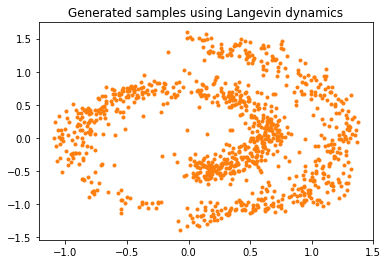

In [11]:
plt.plot(samples[:, 0], samples[:, 1], 'C1.')
plt.title('Generated samples using Langevin dynamics')

# Part 2: Denoising Score matching

# 2-1 Noise conditional Neural Network

Defining the neural network that will learn the score function. This is just a simple multi-layer perceptron with LogSigmoid activation function. In contrast to the previous part, the neural network here takes n+1 inputs and produces n outputs. The additional 1 input is for the noise in $t_i$

In [12]:
# score_network takes input of 2 + 1 (noise) and returns the output of the same size (2)
score_network2 = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)


# 2-2 Score Matching

Loss function:
$$\begin{equation}
\mathcal{L}(\theta) = \frac{1}{L}\sum_{i=1}^{L}{λ(σ_i)}\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x}), \mathbf{\tilde{x}}\sim q_{σ_i}(\mathbf{\tilde{x}|x})}\left[\frac{1}{2} \left\lVert\mathbf{s_\theta}(\mathbf{\tilde{x}, σ_i}) - \nabla_\mathbf{\tilde{x}} \mathbf{log q_{σ_i}}(\mathbf{\tilde{x}|x})\right\rVert^2\right]
\end{equation}$$

$$\begin{equation}
=\frac{1}{L}\sum_{i=1}^{L}\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x}), \mathbf{z}\sim\mathcal{N}(\mathbf{0}, \mathbf{I})}\left[\frac{1}{2} \left\lVert\mathbf{\sigma_i s_\theta}(\mathbf{x+σ_iz, σ_i})+ z\right\rVert^2\right] + const.
\end{equation}$$


In [13]:
sigmas = torch.linspace(0.001, 0.04, steps=1000)
L = 1000


def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    # Sampling a mini-batch from noise scale indices
    sig_idx = torch.randperm(len(sigmas))[:len(x)]
    sig_samples = sigmas[sig_idx].view(-1,1)
    # Sampling a mini-batch from Gaussian noise
    z = torch.randn_like(x)
    perturbed_inputs = x + sig_samples * z
    net_input = torch.cat([perturbed_inputs, sig_samples],dim = 1)
    term_one = score_network2(net_input) * sig_samples
    loss = torch.mean(0.5 * (torch.norm(term_one + z, dim=1) ** 2))

    return loss

# 2-3 Training

In [15]:
# start the training loop
import time
optim = torch.optim.Adam(score_network2.parameters(), lr = 3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size = 256, shuffle=True)
t0 = time.time()
train_loss2 = []
for i_epoch in range(20000):
    total_loss = 0
    for data, in dloader:
        optim.zero_grad()

        # training step
        loss = calc_loss(score_network2, data)
        loss.backward()
        optim.step()
        
        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]
    
    # print the training stats
    if i_epoch % 1000 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")
    train_loss2 = np.append(train_loss2 ,loss.item())

0 (0.018867969512939453s): 0.9891771564483642
1000 (15.091500997543335s): 1.012560329914093
2000 (28.226950883865356s): 1.0238212537765503
3000 (41.8674750328064s): 0.9901866960525513
4000 (55.33788561820984s): 0.921984757900238
5000 (69.18789553642273s): 1.0241402215957642
6000 (83.7663950920105s): 1.0112360696792602
7000 (99.26833653450012s): 0.9917578029632569
8000 (116.99101114273071s): 0.925668291091919
9000 (134.890718460083s): 1.0102296919822693
10000 (153.77783823013306s): 1.0362672080993653
11000 (173.11637210845947s): 1.019203236579895
12000 (193.37780857086182s): 1.0085826892852783
13000 (214.76559162139893s): 0.9462062759399414
14000 (237.37019634246826s): 0.951680317401886
15000 (263.071382522583s): 0.9804962816238403
16000 (287.61929965019226s): 1.0589520015716554
17000 (312.37021136283875s): 0.9715291652679443
18000 (336.8734612464905s): 0.9993920793533325
19000 (361.05189323425293s): 0.9357013144493103


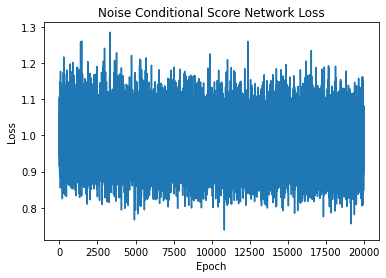

In [16]:
plt.plot(train_loss2)
plt.title('Noise Conditional Score Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 2-4 Generation

Generate the samples using Annealed Langevin dynamics:

$$\begin{equation}
    \mathbf{x}_{i + 1} = \mathbf{x}_i + \frac{α_i}{2}\mathbf{s_\theta}(\mathbf{x+σ_iz, σ_i}) + \sqrt{\alpha_i}\mathbf{z}_i
\end{equation}$$

where $\mathbf{z}_i\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a random number sampled from the normal distribution and $\mathbf{α_i=ϵ.\frac{σ_i}{σ_L}}$




In [23]:
def generate_samples_2(score_net: torch.nn.Module, nsamples: int, eps: float = 0.01) -> torch.Tensor:

    new_x = torch.rand(nsamples, 2)    
    t0 = time.time()
    # for i in range(L):
    sigma,_ = torch.sort(sigmas, descending = True)
    sigma = sigma.view(-1,1)
    alpha = (eps * (sigma / sigmas[-1]))
      
    for t in range(nsamples):
      z_t = torch.randn_like(new_x) 
      perturbed_inputs = new_x + sigma * z_t
      net_input = torch.cat([perturbed_inputs, sigma],dim = 1)
      new_x = new_x + ((alpha/2) * score_net(net_input)) +  (alpha ** 0.5) * z_t
      
      if t % 50 == 0:
        print(f"{t}, {time.time() - t0}s")
      
    return new_x
    
    

with torch.no_grad():
  samples2 = generate_samples_2(score_network2, 1000)


0, 0.01159524917602539s
50, 0.6168804168701172s
100, 1.0121967792510986s
150, 1.5921287536621094s
200, 2.0708718299865723s
250, 2.3281240463256836s
300, 2.5826549530029297s
350, 2.8278682231903076s
400, 3.069114923477173s
450, 3.3203794956207275s
500, 3.5667266845703125s
550, 3.8094587326049805s
600, 4.0536298751831055s
650, 4.297529220581055s
700, 4.55481743812561s
750, 4.791627883911133s
800, 5.028670072555542s
850, 5.266448259353638s
900, 5.508517265319824s
950, 5.748680114746094s


Text(0.5, 1.0, 'Generated samples using Annealed Langevin dynamics')

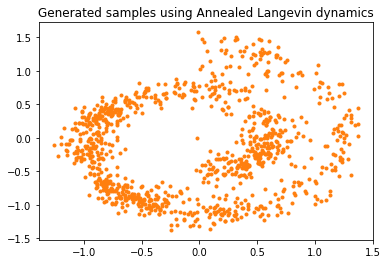

In [28]:
plt.plot(samples2[:, 0], samples2[:, 1], 'C1.')
plt.title('Generated samples using Annealed Langevin dynamics')